# TTC Delay Data Preprocessing - Task Template

**Goal:** Clean and preprocess delay data from 2024 and 2025 for Phase 1 modeling

**Approach:** Regression — predict how many minutes a train/bus will be delayed

**Input Files:**
- `ttc-subway-delay-2024.xlsx`
- `ttc-subway-delay-data-since-2025.csv`

**Output File:**
- `cleaned_ttc_delay_data.csv`

**Target Variable:** `min_delay_capped` (delay in minutes, capped at 60 min to handle outliers)

---

## Setup & Imports

Import required libraries and load both datasets.

In [82]:
# TODO: Import pandas, numpy, and any other libraries you need
# Hint: You'll need pandas for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# TODO: Load 2024 Excel file
# Hint: Use pd.read_excel() with sheet_name='Subway'
# Store in variable: df_2024
df_2024 = pd.read_excel('../data/raw/ttc-subway-delay-2024.xlsx', sheet_name='Subway')


In [129]:
# TODO: Load 2025 CSV file
# Hint: Use pd.read_csv()
# Store in variable: df_2025
df_2025 = pd.read_csv('../data/raw/ttc-subway-delay-data-since-2025.csv')

In [130]:
# TODO: Combine both dataframes
# Hint: Use pd.concat() with ignore_index=True
# Store in variable: df (this will be your main dataframe)
df = pd.concat([df_2024, df_2025], ignore_index=True)

In [131]:
# TODO: Inspect the combined dataframe
# Hint: Check shape, columns, first few rows, data types, info()
print("Shape of combined dataframe:", df.shape)
print("Columns in combined dataframe:", df.columns)
print("First 5 rows of combined dataframe:")
print(df.head())
print("Data types of combined dataframe:")
print(df.dtypes)
print("Info of combined dataframe:")
print(df.info())


Shape of combined dataframe: (52180, 11)
Columns in combined dataframe: Index(['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap',
       'Bound', 'Line', 'Vehicle', '_id'],
      dtype='str')
First 5 rows of combined dataframe:
                  Date   Time     Day             Station   Code  Min Delay  \
0  2024-01-01 00:00:00  02:00  Monday    SHEPPARD STATION    MUI          0   
1  2024-01-01 00:00:00  02:00  Monday      DUNDAS STATION   MUIS          0   
2  2024-01-01 00:00:00  02:08  Monday      DUNDAS STATION  MUPAA          4   
3  2024-01-01 00:00:00  02:13  Monday  KENNEDY BD STATION  PUTDN         10   
4  2024-01-01 00:00:00  02:22  Monday       BLOOR STATION  MUPAA          4   

   Min Gap Bound Line  Vehicle  _id  
0        0     N   YU     5491  NaN  
1        0     N   YU        0  NaN  
2       10     N   YU     6051  NaN  
3       16     E   BD     5284  NaN  
4       10     N   YU     5986  NaN  
Data types of combined dataframe:
Date          object

---

## Task 1: Standardize Line Names

**Objective:** Map all inconsistent line names to canonical forms (Line 1, Line 2, Line 4)

**Current Issues:**
- YU, YU/BD, YU / BD, YU/ BD, LINE 1 → Should all be "Line 1"
- BD, BLOOR DANFORTH, BD/YU, BD / YU → Should all be "Line 2"
- SHP, SHEP → Should be "Line 4"
- Invalid: 109 RANEE, 20 CLIFFSIDE, TRACK LEVEL ACTIVITY → Should be removed

**Hints:**
1. First, check `df['Line'].unique()` to see all variations
2. Create a mapping dictionary with old name → new name
3. Use `.map()` or `.replace()` to apply the mapping
4. For multi-line entries (YU/BD), decide: keep as "Line 1/2" or drop
5. Verify after mapping: check unique values again

In [132]:
# TODO: Examine current Line values
# Print unique values and counts
# Hint: df['Line'].unique() and df['Line'].value_counts()
print("Unique Line values:")
print(df['Line'].unique())
print("\nLine value counts:")
print(df['Line'].value_counts())


Unique Line values:
<StringArray>
[                    'YU',                     'BD',                    'YUS',
                  'YU/BD',                    'SHP',                      nan,
         'BLOOR DANFORTH',                'YU / BD',                 'YU/ BD',
                    'SRT',                 'YUS/BD',                   'SHEP',
                 'LINE 1',   'TRACK LEVEL ACTIVITY',                'YU & BD',
              '109 RANEE', 'ONGE-UNIVERSITY AND BL',              'YU/BD/SHP',
                'BD/ YUS',                 'BD/ YU',                  'BD/YU',
                'BD / YU',           '20 CLIFFSIDE',                'YUS/ BD',
                 'BD/YUS',           'YUS/ BD/ SHP',               'YUS / BD',
           'YU -BD LINES',            '29 DUFFERIN',            'YU/BD LINES']
Length: 30, dtype: str

Line value counts:
Line
YU                        27221
BD                        22133
SHP                        1955
YU/BD                       655


In [133]:
# TODO: Create mapping dictionary
# Map all variations to canonical names
# Example structure:
# line_mapping = {
#     'YU': 'Line 1',
#     'YU/BD': 'Line 1/2',
#     ... (add all variations)
# }
# Hint: Reference the task guide for all 22 variations
line_mapping = {
    # Line 1 (Yonge-University)
    'YU': 'Line 1',
    'YUS': 'Line 1',
    'LINE 1': 'Line 1',

    # Line 2 (Bloor-Danforth)
    'BD': 'Line 2',
    'BLOOR DANFORTH': 'Line 2',

    # Line 4 (Sheppard)
    'SHP': 'Line 4',
    'SHEP': 'Line 4',

    # Line 3 (Scarborough RT - legacy, decommissioned)
    'SRT': 'Line 3',

    # Multi-line: Line 1 / Line 2
    'YU/BD': 'Line 1/2',
    'YU/ BD': 'Line 1/2',
    'YU / BD': 'Line 1/2',
    'YU & BD': 'Line 1/2',
    'YU/BD LINES': 'Line 1/2',
    'YU -BD LINES': 'Line 1/2',
    'BD/YU': 'Line 1/2',
    'BD/ YU': 'Line 1/2',
    'BD / YU': 'Line 1/2',
    'YUS/BD': 'Line 1/2',
    'YUS / BD': 'Line 1/2',
    'YUS/ BD': 'Line 1/2',
    'BD/YUS': 'Line 1/2',
    'BD/ YUS': 'Line 1/2',
    'ONGE-UNIVERSITY AND BL': 'Line 1/2',

    # Multi-line: Line 1 / Line 2 / Line 4
    'YU/BD/SHP': 'Line 1/2/4',
    'YUS/ BD/ SHP': 'Line 1/2/4',

    # Invalid entries (to be removed in Task 2)
    '109 RANEE': None,
    '20 CLIFFSIDE': None,
    '29 DUFFERIN': None,
    'TRACK LEVEL ACTIVITY': None,
}


In [134]:
# TODO: Apply mapping to Line column
# Hint: Use df['Line'].map(line_mapping) or df['Line'].replace(line_mapping)
df['Line'] = df['Line'].map(line_mapping)

In [135]:
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,_id
0,2024-01-01 00:00:00,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,Line 1,5491,NaN
1,2024-01-01 00:00:00,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,Line 1,0,NaN
2,2024-01-01 00:00:00,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,Line 1,6051,NaN
3,2024-01-01 00:00:00,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,Line 2,5284,NaN
4,2024-01-01 00:00:00,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,Line 1,5986,NaN


In [136]:
# TODO: Verify mapping worked
# Check unique values after mapping
# Should see only: Line 1, Line 2, Line 4, Line 1/2, etc. (canonical forms)
print("Unique Line values after mapping:")
print(df['Line'].unique())


Unique Line values after mapping:
<StringArray>
['Line 1', 'Line 2', 'Line 1/2', 'Line 4', nan, 'Line 3', 'Line 1/2/4']
Length: 7, dtype: str


---

## Task 2: Remove Invalid Records

**Objective:** Remove rows with missing or erroneous Line values

**Records to Remove:**
- ~44-67 rows with null/NaN Line values
- Erroneous entries like "109 RANEE", "20 CLIFFSIDE", "TRACK LEVEL ACTIVITY"

**Hints:**
1. Check `df['Line'].isnull().sum()` to count nulls
2. Use `df.dropna(subset=['Line'])` to remove null rows
3. Use `df[~df['Line'].isin(['list', 'of', 'invalid', 'values'])]` to filter invalid entries
4. Log record counts before and after to confirm removal
5. Expected result: ~52,000-52,064 records remaining

In [137]:
# TODO: Check for null Line values
# Print count of nulls and percentage
# Hint: df['Line'].isnull().sum()
df['Line'].isnull().sum()

np.int64(115)

In [138]:
# TODO: Remove rows with null Line
# Store record count before and after
# Hint: Use .dropna() or boolean indexing
# Store count before
records_before = len(df)

# Remove rows with null Line
df = df.dropna(subset=['Line'])

# Store count after
records_after = len(df)

print(f"Before: {records_before}")
print(f"After:  {records_after}")
print(f"Removed: {records_before - records_after} rows with null Line")


Before: 52180
After:  52065
Removed: 115 rows with null Line


In [139]:
print(df['Line'].unique())

<StringArray>
['Line 1', 'Line 2', 'Line 1/2', 'Line 4', 'Line 3', 'Line 1/2/4']
Length: 6, dtype: str


---

## Task 2b: Cap Outliers in Min Delay

**Objective:** Create `min_delay_capped` column with extreme values capped at 60 minutes

**Why:**
- Max delay is 900 min — extreme outliers will distort the regression model
- 124 records have delay > 60 min, only 40 > 120 min
- Capping at 60 min preserves 99.8% of data distribution while removing noise

**Target Variable:** `min_delay_capped` will be the regression target (predicting delay in minutes)

**Hints:**
1. Use `.clip(upper=60)` to cap values
2. Verify: max should be 60, min should be 0
3. Compare distribution before and after capping

In [140]:
# Cap extreme outliers at 60 minutes for the regression target
print(f"Before capping — Max: {df['Min Delay'].max()}, Records > 60 min: {(df['Min Delay'] > 60).sum()}")

df['min_delay_capped'] = df['Min Delay'].clip(upper=60)

print(f"After capping  — Max: {df['min_delay_capped'].max()}, Min: {df['min_delay_capped'].min()}")
print(f"\nmin_delay_capped distribution:")
print(df['min_delay_capped'].describe())

Before capping — Max: 900, Records > 60 min: 124
After capping  — Max: 60, Min: 0

min_delay_capped distribution:
count    52065.000000
mean         2.599866
std          5.740377
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max         60.000000
Name: min_delay_capped, dtype: float64


---

## Task 3: Parse Time Column

**Objective:** Extract hour from Time column (HH:MM format → integer 0-23)

**Current Format:** Text like "02:00", "08:46", "17:05"

**Hints:**
1. Create function to parse time strings
2. Split on ":" character and take first part
3. Convert to integer
4. Use `.apply()` to apply function to entire column
5. Verify: all values should be 0-23, no nulls
6. Drop original Time column after extraction

In [141]:
# TODO: Examine Time column
# Check sample values, data type, unique counts
# Hint: df['Time'].head(10), df['Time'].dtype
print("Sample values:")
print(df['Time'].head(10))
print(f"\nData type: {df['Time'].dtype}")
print(f"Unique count: {df['Time'].nunique()}")
print(f"Nulls: {df['Time'].isnull().sum()}")


Sample values:
0    02:00
1    02:00
2    02:08
3    02:13
4    02:22
5    02:25
6    02:25
7    02:27
8    02:28
9    02:30
Name: Time, dtype: str

Data type: str
Unique count: 1436
Nulls: 0


In [142]:
# TODO: Create function to extract hour
# Function should:
# - Take time string as input
# - Split on ':'
# - Return first part as integer
# - Handle errors gracefully
# Hint: def extract_hour(time_str):
def extract_hour(time_str):
    try:
        return int(time_str.split(':')[0])
    except (ValueError, AttributeError):
        return None


In [143]:
# TODO: Create 'hour' column
# Apply function to Time column
# Hint: df['hour'] = df['Time'].apply(extract_hour)
df['hour'] = df['Time'].apply(extract_hour)
print(df[['Time', 'hour']].head(10))


    Time  hour
0  02:00     2
1  02:00     2
2  02:08     2
3  02:13     2
4  02:22     2
5  02:25     2
6  02:25     2
7  02:27     2
8  02:28     2
9  02:30     2


In [144]:
# TODO: Validate hour values
# Check: min, max, data type, any nulls
# Should be: min=0, max=23, type=int, nulls=0
print(f"Min: {df['hour'].min()}")
print(f"Max: {df['hour'].max()}")
print(f"Dtype: {df['hour'].dtype}")
print(f"Nulls: {df['hour'].isnull().sum()}")


Min: 0
Max: 23
Dtype: int64
Nulls: 0


In [145]:
# TODO: Drop Time column (no longer needed)
# Hint: df.drop(columns=['Time'])
df = df.drop(columns=['Time'])
print(df.columns.tolist())


['Date', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Line', 'Vehicle', '_id', 'min_delay_capped', 'hour']


---

## Task 4: Parse Date Column

**Objective:** Ensure Date is datetime format and extract temporal features (year, month, week)

**Current State:**
- 2024 file: already datetime
- 2025 file: text format "2025-01-01"

**Hints:**
1. Check current data type: `df['Date'].dtype`
2. Convert to datetime: `pd.to_datetime(df['Date'])`
3. Extract year: `df['Date'].dt.year`
4. Extract month: `df['Date'].dt.month`
5. Extract week: `df['Date'].dt.isocalendar().week`
6. Verify: year should be 2024 or 2025, month 1-12, week 1-53

In [146]:
# TODO: Check current Date format
# Check data type and sample values
# Hint: df['Date'].dtype, df['Date'].head()
print(f"Dtype: {df['Date'].dtype}")
print(f"\nSample values:")
print(df['Date'].head(10))


Dtype: object

Sample values:
0    2024-01-01 00:00:00
1    2024-01-01 00:00:00
2    2024-01-01 00:00:00
3    2024-01-01 00:00:00
4    2024-01-01 00:00:00
5    2024-01-01 00:00:00
6    2024-01-01 00:00:00
7    2024-01-01 00:00:00
8    2024-01-01 00:00:00
9    2024-01-01 00:00:00
Name: Date, dtype: object


In [147]:
# TODO: Convert Date to datetime
# Hint: df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
print(f"Dtype: {df['Date'].dtype}")


Dtype: datetime64[us]


In [148]:
# TODO: Extract year
# Create column 'year' with values 2024 or 2025
# Hint: df['year'] = df['Date'].dt.year
df['year'] = df['Date'].dt.year
print(df['year'].value_counts())


year
2024    26420
2025    25645
Name: count, dtype: int64


In [149]:
# TODO: Extract month
# Create column 'month' with values 1-12
# Hint: df['month'] = df['Date'].dt.month
df['month'] = df['Date'].dt.month
print(df['month'].value_counts().sort_index())


month
1     4357
2     4365
3     4202
4     4353
5     4551
6     3868
7     4155
8     5036
9     3986
10    4292
11    4341
12    4559
Name: count, dtype: int64


In [150]:
# TODO: Extract week
# Create column 'week' with values 1-53
# Hint: df['week'] = df['Date'].dt.isocalendar().week
df['week'] = df['Date'].dt.isocalendar().week
print(f"Min: {df['week'].min()}, Max: {df['week'].max()}")


Min: 1, Max: 52


In [151]:
# TODO: Validate temporal columns
# Check ranges: year (2024-2025), month (1-12), week (1-53)
# Check for any nulls
for col, expected_range in [('year', (2024, 2025)), ('month', (1, 12)), ('week', (1, 53))]:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}, nulls={df[col].isnull().sum()}, range_ok={df[col].min() >= expected_range[0] and df[col].max() <= expected_range[1]}")


year: min=2024, max=2025, nulls=0, range_ok=True
month: min=1, max=12, nulls=0, range_ok=True
week: min=1, max=52, nulls=0, range_ok=True


---

## Task 5: Create Binary Delay Feature

**Objective:** Create binary `is_delayed` column (0=on-time, 1=delayed) as a **feature** for the regression model

**Note:** This is NOT the target variable. The target is `min_delay_capped` (created in Task 2b).
The `is_delayed` column adds signal to the model as an additional feature.

**Decision:** What threshold defines "delayed"?
- Threshold of 3 gives a 35.4%/64.6% split

**Hints:**
1. Analyze Min Delay distribution first (percentiles, mean, median, max)
2. Create rule: if Min Delay >= threshold, then 1, else 0
3. Verify: column should have only 0 and 1, no nulls

In [152]:
# TODO: Analyze Min Delay distribution
# Calculate: min, max, mean, median, percentiles (25, 50, 75)
# Hint: df['Min Delay'].describe()
print(df['Min Delay'].describe())


count    52065.000000
mean         2.784366
std         10.610422
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        900.000000
Name: Min Delay, dtype: float64


In [153]:
# TODO: Decide on delay threshold
# Set variable: threshold = 5 (or your chosen value)
# Comment why you chose this threshold
# 5 minutes: standard transit threshold — delays under 5 min
# are considered normal service variation

Distribution of Min Delay:
count    52065.000000
mean         2.784366
std         10.610422
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
90%          7.000000
95%         11.000000
max        900.000000
Name: Min Delay, dtype: float64

--- Class balance at different thresholds ---
Threshold= 1min → Delayed: 18,485 (35.5%) | On-time: 33,580 (64.5%)
Threshold= 2min → Delayed: 18,485 (35.5%) | On-time: 33,580 (64.5%)
Threshold= 3min → Delayed: 18,437 (35.4%) | On-time: 33,628 (64.6%)
Threshold= 5min → Delayed: 10,347 (19.9%) | On-time: 41,718 (80.1%)
Threshold=10min → Delayed: 3,430 (6.6%) | On-time: 48,635 (93.4%)
Threshold=15min → Delayed: 1,777 (3.4%) | On-time: 50,288 (96.6%)

--- Median and Mean ---
Median: 0.0 min
Mean:   2.78 min


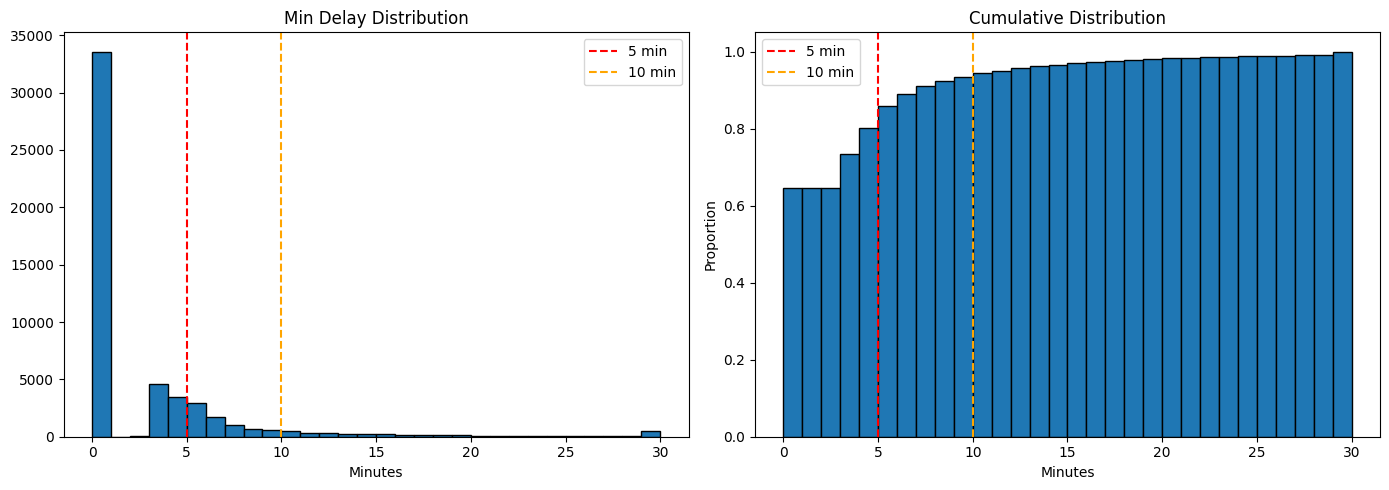

In [154]:
print("Distribution of Min Delay:")
print(df['Min Delay'].describe(percentiles=[.25, .5, .75, .90, .95]))

print("\n--- Class balance at different thresholds ---")
for t in [1, 2, 3, 5, 10, 15]:
    delayed = (df['Min Delay'] >= t).sum()
    total = len(df)
    print(f"Threshold={t:2d}min → Delayed: {delayed:,} ({delayed/total*100:.1f}%) | On-time: {total-delayed:,} ({(total-delayed)/total*100:.1f}%)")

print("\n--- Median and Mean ---")
print(f"Median: {df['Min Delay'].median()} min")
print(f"Mean:   {df['Min Delay'].mean():.2f} min")

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (capped at 30 min for readability)
axes[0].hist(df['Min Delay'].clip(upper=30), bins=30, edgecolor='black')
axes[0].axvline(x=5, color='red', linestyle='--', label='5 min')
axes[0].axvline(x=10, color='orange', linestyle='--', label='10 min')
axes[0].set_title('Min Delay Distribution')
axes[0].set_xlabel('Minutes')
axes[0].legend()

# Cumulative distribution
axes[1].hist(df['Min Delay'].clip(upper=30), bins=30, cumulative=True, density=True, edgecolor='black')
axes[1].axvline(x=5, color='red', linestyle='--', label='5 min')
axes[1].axvline(x=10, color='orange', linestyle='--', label='10 min')
axes[1].set_title('Cumulative Distribution')
axes[1].set_xlabel('Minutes')
axes[1].set_ylabel('Proportion')
axes[1].legend()

plt.tight_layout()
plt.show()


### Key Findings

- **64.5%** of records have `Min Delay = 0` (no delay at all)
- **Median is 0** — most incidents don't cause actual delay
- **Mean is 2.78 min** — skewed by a few extreme values (max 900 min)
- The 75th percentile is **4 min**, 90th is **7 min**

### Class Balance by Threshold

| Threshold | Delayed % | On-time % | Verdict |
|-----------|-----------|-----------|---------|
| 1 min | 35.5% | 64.5% | Too loose — counts trivial 1-2 min as "delayed" |
| 3 min | 35.4% | 64.6% | Same issue — barely different from 1 min |
| **4 min** | **26.6%** | **73.4%** | **Good balance, sits at 75th percentile** |
| 5 min | 19.9% | 80.1% | Getting imbalanced (~1:4 ratio) |
| 10 min | 6.6% | 93.4% | Too strict — model won't learn enough |

### Decision: threshold = 4

- Aligns with the **75th percentile** — meaning "delayed" = worse than 75% of incidents
- Gives a **~27/73 split**, which is healthy for a classification model (not too imbalanced)
- Threshold of 5 gives only 20% delayed, which starts to cause class imbalance issues during training


In [155]:
threshold = 3 # we can change it to 2 or 1 

In [156]:
# TODO: Create is_delayed column
# If Min Delay >= threshold, then 1, else 0
# Hint: df['is_delayed'] = (df['Min Delay'] >= threshold).astype(int)
df['is_delayed'] = (df['Min Delay'] >= threshold).astype(int)
print(df['is_delayed'].value_counts())
print(f"\nDelayed: {df['is_delayed'].mean()*100:.1f}%")


is_delayed
0    33628
1    18437
Name: count, dtype: int64

Delayed: 35.4%


In [157]:
# TODO: Check class distribution
# Count of 0s and 1s, and percentages
# Hint: df['is_delayed'].value_counts() and normalized version
print("Class distribution:")
print(df['is_delayed'].value_counts())
print(f"\nPercentages:")
print(df['is_delayed'].value_counts(normalize=True) * 100)


Class distribution:
is_delayed
0    33628
1    18437
Name: count, dtype: int64

Percentages:
is_delayed
0    64.588495
1    35.411505
Name: proportion, dtype: float64


In [158]:
# TODO: Validate target variable
# Check: only 0 and 1 values, no nulls, data type is int
print(f"Unique values: {df['is_delayed'].unique()}")
print(f"Nulls: {df['is_delayed'].isnull().sum()}")
print(f"Dtype: {df['is_delayed'].dtype}")


Unique values: [0 1]
Nulls: 0
Dtype: int64


---

## Task 6: Create Day-of-Week Numeric

**Objective:** Convert day names (Monday, Tuesday, etc.) to numeric (0-6)

**Mapping:**
- Monday → 0
- Tuesday → 1
- ... 
- Sunday → 6

**Hints:**
1. Create mapping dictionary with day names as keys
2. Use `.map()` to apply mapping
3. Verify: values should be 0-6 only, no nulls
4. Spot-check: verify a few rows match expected days

In [159]:
# TODO: Check current Day column
# See unique values
# Hint: df['Day'].unique()
print(df['Day'].unique())
print(f"\nCount: {df['Day'].nunique()}")


<StringArray>
['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Length: 7, dtype: str

Count: 7


In [160]:
# TODO: Create day mapping dictionary
# Map day names to 0-6
# Example: {'Monday': 0, 'Tuesday': 1, ...}
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}


In [161]:
# TODO: Create day_of_week column
# Apply mapping to Day column
# Hint: df['day_of_week'] = df['Day'].map(day_mapping)
df['day_of_week'] = df['Day'].map(day_mapping)
print(df[['Day', 'day_of_week']].head(10))


      Day  day_of_week
0  Monday            0
1  Monday            0
2  Monday            0
3  Monday            0
4  Monday            0
5  Monday            0
6  Monday            0
7  Monday            0
8  Monday            0
9  Monday            0


In [162]:
# TODO: Validate day_of_week
# Check: values 0-6 only, no nulls, data type is int
# Spot-check a few rows
print(f"Min: {df['day_of_week'].min()}, Max: {df['day_of_week'].max()}")
print(f"Nulls: {df['day_of_week'].isnull().sum()}")
print(f"Dtype: {df['day_of_week'].dtype}")
print(f"\nSpot-check:")
print(df[['Day', 'day_of_week']].drop_duplicates().sort_values('day_of_week'))


Min: 0, Max: 6
Nulls: 0
Dtype: int64

Spot-check:
           Day  day_of_week
0       Monday            0
56     Tuesday            1
124  Wednesday            2
185   Thursday            3
280     Friday            4
344   Saturday            5
410     Sunday            6


---

## Task 7: Create Weekday Indicator

**Objective:** Create binary column 'is_weekend' (0=Mon-Fri, 1=Sat-Sun)

**Logic:**
- If day_of_week >= 5 (Saturday or Sunday), then 1
- Else 0

**Hints:**
1. Use comparison operator: `df['day_of_week'] >= 5`
2. Convert boolean to int with `.astype(int)`
3. Verify: only 0 and 1 values
4. Spot-check: Saturday and Sunday rows should be 1

In [163]:
# TODO: Create is_weekend column
# 1 if day_of_week >= 5, else 0
# Hint: df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
print(df[['Day', 'day_of_week', 'is_weekend']].drop_duplicates().sort_values('day_of_week'))


           Day  day_of_week  is_weekend
0       Monday            0           0
56     Tuesday            1           0
124  Wednesday            2           0
185   Thursday            3           0
280     Friday            4           0
344   Saturday            5           1
410     Sunday            6           1


In [164]:
# TODO: Validate is_weekend
# Check: only 0 and 1 values, no nulls
# Spot-check: verify Saturday/Sunday are marked as 1
print(f"Unique values: {df['is_weekend'].unique()}")
print(f"Nulls: {df['is_weekend'].isnull().sum()}")
print(f"Dtype: {df['is_weekend'].dtype}")


Unique values: [0 1]
Nulls: 0
Dtype: int64


---

## Task 8: Calculate Historical Average Delays

**Objective:** Create features showing historical average delay patterns (in minutes)

**Three features to create:**
1. **route_avg_delay** — average delay in minutes by Line
2. **route_hour_avg_delay** — average delay in minutes by Line + Hour
3. **route_day_hour_avg_delay** — average delay in minutes by Line + Day + Hour

**Why averages instead of frequencies:**
Since we are predicting delay in minutes (regression), average delay per group
is more informative than binary delay percentage.

**Hints:**
1. Group by Line, calculate mean of `min_delay_capped`
2. Map back to all rows with the same Line
3. Repeat for Line+Hour and Line+Day+Hour combinations
4. All values should be >= 0 (average minutes)
5. Verify: no nulls in any average delay columns

In [165]:
# Calculate route-level average delay (in minutes)
# Group by Line, calculate mean of min_delay_capped
route_avg = df.groupby('Line')['min_delay_capped'].mean()
df['route_avg_delay'] = df['Line'].map(route_avg)
print("Average delay by Line (minutes):")
print(route_avg)

Average delay by Line (minutes):
Line
Line 1        2.860133
Line 1/2      0.000000
Line 1/2/4    0.000000
Line 2        2.352354
Line 3        0.000000
Line 4        2.763292
Name: min_delay_capped, dtype: float64


In [166]:
# Calculate route-hour average delay (in minutes)
# Group by Line + Hour, calculate mean of min_delay_capped
route_hour_avg = df.groupby(['Line', 'hour'])['min_delay_capped'].mean()
df['route_hour_avg_delay'] = df.set_index(['Line', 'hour']).index.map(route_hour_avg)
print("Sample route-hour averages:")
print(route_hour_avg.head(10))

Sample route-hour averages:
Line    hour
Line 1  0       2.499487
        1       2.353526
        2       0.623867
        3       0.216049
        4       0.621951
        5       4.030488
        6       4.135285
        7       2.974729
        8       2.999338
        9       2.832714
Name: min_delay_capped, dtype: float64


In [167]:
# Calculate route-day-hour average delay (in minutes)
# Group by Line + Day + Hour, calculate mean of min_delay_capped
route_day_hour_avg = df.groupby(['Line', 'day_of_week', 'hour'])['min_delay_capped'].mean()
df['route_day_hour_avg_delay'] = df.set_index(['Line', 'day_of_week', 'hour']).index.map(route_day_hour_avg)
print("Sample route-day-hour averages:")
print(route_day_hour_avg.head(10))

Sample route-day-hour averages:
Line    day_of_week  hour
Line 1  0            0       2.457944
                     1       3.217687
                     2       0.630631
                     3       0.090909
                     4       0.000000
                     5       3.502793
                     6       3.954167
                     7       2.848315
                     8       2.860558
                     9       2.227545
Name: min_delay_capped, dtype: float64


In [168]:
# Validate average delay columns
# Check: all values >= 0, no nulls
for col in ['route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']:
    print(f"{col}: min={df[col].min():.2f}, max={df[col].max():.2f}, nulls={df[col].isnull().sum()}")

route_avg_delay: min=0.00, max=2.86, nulls=0
route_hour_avg_delay: min=0.00, max=4.18, nulls=0
route_day_hour_avg_delay: min=0.00, max=11.50, nulls=0


---

## Task 9: Handle Missing Bound Column

**Objective:** Decide what to do with Bound column (has ~36% missing values)

**Decision Point:**
- **Option A (Recommended): Drop the column** - Simpler, not needed for Phase 1
- Option B: Keep and note the missing values

**Hints:**
1. Check current Bound values: `df['Bound'].unique()` and null count
2. If choosing Option A: use `df.drop(columns=['Bound'])`
3. If choosing Option B: create `has_bound` indicator (optional)

In [169]:
# TODO: Examine Bound column
# Check unique values, null count, percentage
# Hint: df['Bound'].value_counts(dropna=False)
print(df['Bound'].value_counts(dropna=False))
print(f"\nNulls: {df['Bound'].isnull().sum()} ({df['Bound'].isnull().sum()/len(df)*100:.1f}%)")


Bound
NaN    18877
S       9100
N       8365
E       7937
W       7737
B         49
Name: count, dtype: int64

Nulls: 18877 (36.3%)


In [170]:
# TODO: Drop Bound column
# Since not needed for Phase 1
# Hint: df = df.drop(columns=['Bound'])
# OR: Keep it if you prefer
df = df.drop(columns=['Bound'])
print(df.columns.tolist())


['Date', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Line', 'Vehicle', '_id', 'min_delay_capped', 'hour', 'year', 'month', 'week', 'is_delayed', 'day_of_week', 'is_weekend', 'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']


---

## Task 10: Final Validation

**Objective:** Verify all preprocessing is complete and correct

**Validation Checklist:**
1. No null values in critical columns (Line, hour, day_of_week, is_delayed, is_weekend, min_delay_capped)
2. Data types correct (int, float, datetime, object)
3. Value ranges correct (hour 0-23, day_of_week 0-6, min_delay_capped 0-60)
4. Record counts reasonable (~52,000-52,065)
5. No unexpected data loss

**Hints:**
1. Use `df.info()` to check data types and nulls
2. Use `df.describe()` to check numeric ranges
3. Create summary table showing column info

In [171]:
# TODO: Check for null values
# List all columns with null counts
# Hint: df.isnull().sum()
print(df.isnull().sum())

Date                            0
Day                             0
Station                         0
Code                            0
Min Delay                       0
Min Gap                         0
Line                            0
Vehicle                         0
_id                         26420
min_delay_capped                0
hour                            0
year                            0
month                           0
week                            0
is_delayed                      0
day_of_week                     0
is_weekend                      0
route_avg_delay                 0
route_hour_avg_delay            0
route_day_hour_avg_delay        0
dtype: int64


In [172]:
df = df.drop(columns=['_id', 'Vehicle'])
print(df.isnull().sum())

Date                        0
Day                         0
Station                     0
Code                        0
Min Delay                   0
Min Gap                     0
Line                        0
min_delay_capped            0
hour                        0
year                        0
month                       0
week                        0
is_delayed                  0
day_of_week                 0
is_weekend                  0
route_avg_delay             0
route_hour_avg_delay        0
route_day_hour_avg_delay    0
dtype: int64


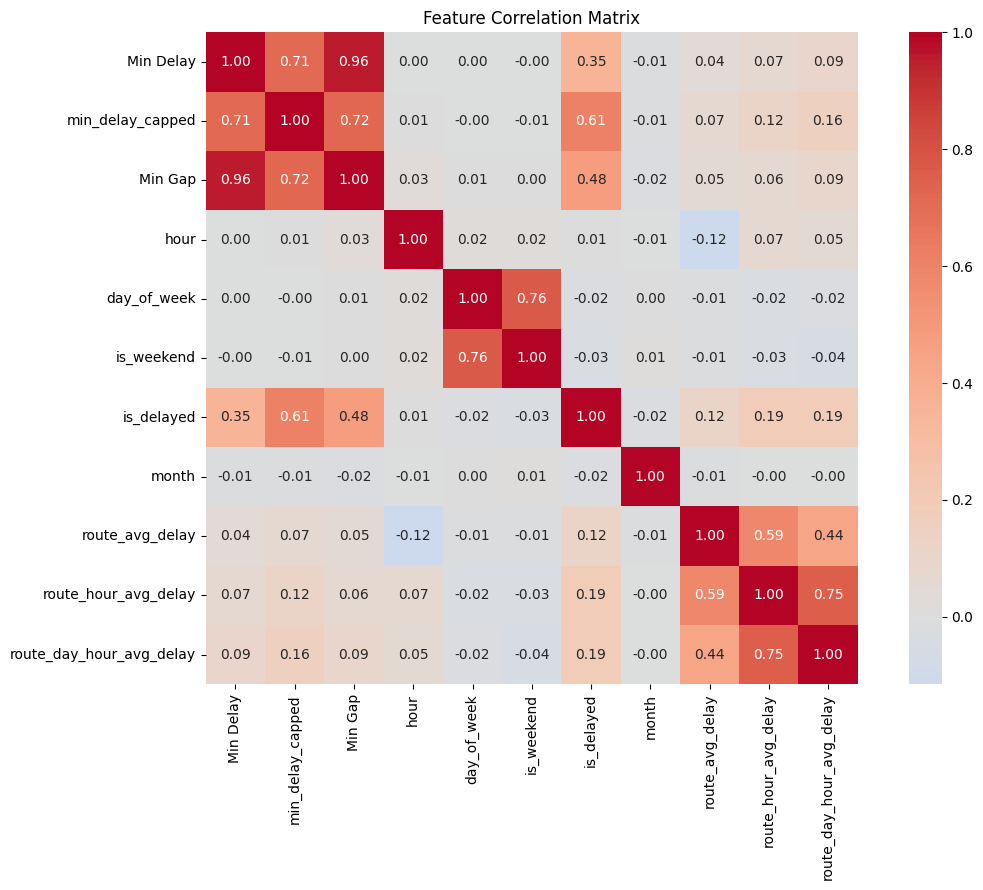

Correlation with min_delay_capped:
min_delay_capped            1.000000
Min Gap                     0.721737
Min Delay                   0.714891
is_delayed                  0.611002
route_day_hour_avg_delay    0.158244
route_hour_avg_delay        0.118621
route_avg_delay             0.069423
hour                        0.008338
day_of_week                -0.003663
is_weekend                 -0.006068
month                      -0.014143
Name: min_delay_capped, dtype: float64


In [173]:
# Correlation matrix for numeric columns
numeric_cols = ['Min Delay', 'min_delay_capped', 'Min Gap', 'hour', 
                'day_of_week', 'is_weekend', 'is_delayed', 'month',
                'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']

corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Specifically check correlation with the target
print("Correlation with min_delay_capped:")
print(corr['min_delay_capped'].sort_values(ascending=False))


### Correlation Analysis

**Strong correlation with target (`min_delay_capped`):**
- `Min Gap` (0.72) — **data leakage**. Gap is only known *after* the delay occurs, not before. Drop for prediction.
- `Min Delay` (0.71) — this is the raw version of the target itself. Must be dropped during training.
- `is_delayed` (0.61) — derived directly from `Min Delay`. Also leakage. Must be dropped during training.

**Useful predictive features:**
- `route_day_hour_avg_delay` (0.16) — best historical feature
- `route_hour_avg_delay` (0.12)
- `route_avg_delay` (0.07)

**Weak individual correlation (but may help in combination):**
- `hour` (0.01), `day_of_week` (-0.00), `is_weekend` (-0.01), `month` (-0.01)

**Multicollinearity concern:**
- The three `route_*_avg_delay` features are highly correlated with each other (0.44–0.75). Consider keeping only `route_day_hour_avg_delay` (the most granular) to avoid redundancy.

**Decision:** Drop `Min Delay`, `Min Gap`, and `is_delayed` before model training — they leak information about the target.


In [174]:
df = df.drop(columns=['Min Delay', 'Min Gap', 'is_delayed'])
print(df.columns.tolist())


['Date', 'Day', 'Station', 'Code', 'Line', 'min_delay_capped', 'hour', 'year', 'month', 'week', 'day_of_week', 'is_weekend', 'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']


In [177]:
# Day is redundant with day_of_week — drop it
df = df.drop(columns=['Day'])
print(df.columns.tolist())


['Date', 'Station', 'Code', 'Line', 'min_delay_capped', 'hour', 'year', 'month', 'week', 'day_of_week', 'is_weekend', 'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']


In [178]:
# TODO: Check data types
# Verify each column has expected type
# Expected:
#   - Line: object/str
#   - hour, day_of_week, is_weekend, is_delayed: int
#   - min_delay_capped, route_avg_delay, route_hour_avg_delay, route_day_hour_avg_delay: float
#   - Date: datetime
# Hint: df.dtypes
# Check data types
# Expected:
#   - Line, Station, Code, Day: str/object
#   - hour, day_of_week, is_weekend, year, month: int
#   - min_delay_capped, route_avg_delay, route_hour_avg_delay, route_day_hour_avg_delay: float
#   - Date: datetime
print(df.dtypes)


Date                        datetime64[us]
Station                                str
Code                                   str
Line                                   str
min_delay_capped                     int64
hour                                 int64
year                                 int32
month                                int32
week                                UInt32
day_of_week                          int64
is_weekend                           int64
route_avg_delay                    float64
route_hour_avg_delay               float64
route_day_hour_avg_delay           float64
dtype: object


In [179]:
# TODO: Check value ranges
# hour: 0-23
# day_of_week: 0-6
# is_weekend: 0-1
# is_delayed: 0-1
# month: 1-12
# min_delay_capped: 0-60 (TARGET)
# route_avg_delay, route_hour_avg_delay, route_day_hour_avg_delay: >= 0
# Hint: df.describe() and custom checks
# Check value ranges
ranges = {
    'hour': (0, 23),
    'day_of_week': (0, 6),
    'is_weekend': (0, 1),
    'month': (1, 12),
    'min_delay_capped': (0, 60),
}

for col, (lo, hi) in ranges.items():
    actual_min, actual_max = df[col].min(), df[col].max()
    ok = actual_min >= lo and actual_max <= hi
    print(f"{col}: min={actual_min}, max={actual_max}, range_ok={ok}")

# Route averages should be >= 0
for col in ['route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']:
    print(f"{col}: min={df[col].min():.2f}, max={df[col].max():.2f}, all_positive={df[col].min() >= 0}")


hour: min=0, max=23, range_ok=True
day_of_week: min=0, max=6, range_ok=True
is_weekend: min=0, max=1, range_ok=True
month: min=1, max=12, range_ok=True
min_delay_capped: min=0, max=60, range_ok=True
route_avg_delay: min=0.00, max=2.86, all_positive=True
route_hour_avg_delay: min=0.00, max=4.18, all_positive=True
route_day_hour_avg_delay: min=0.00, max=11.50, all_positive=True


In [180]:
# TODO: Check record counts by line
# Breakdown of records for each line
# Should see: Line 1, Line 2, Line 4, etc.
# Hint: df['Line'].value_counts()
print(df['Line'].value_counts())
print(f"\nTotal records: {len(df)}")


Line
Line 1        27233
Line 2        22134
Line 4         1956
Line 1/2        736
Line 3            3
Line 1/2/4        3
Name: count, dtype: int64

Total records: 52065


In [181]:
# TODO: Generate validation summary
# Create table showing:
#   - Column name
#   - Data type
#   - Null count
#   - Min/Max (for numeric)
# Hint: Create DataFrame with this info
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'nulls': df.isnull().sum(),
    'min': df.select_dtypes('number').min().reindex(df.columns),
    'max': df.select_dtypes('number').max().reindex(df.columns),
})
print(summary)


                                   dtype  nulls     min       max
Date                      datetime64[us]      0    <NA>      <NA>
Station                              str      0    <NA>      <NA>
Code                                 str      0    <NA>      <NA>
Line                                 str      0    <NA>      <NA>
min_delay_capped                   int64      0     0.0      60.0
hour                               int64      0     0.0      23.0
year                               int32      0  2024.0    2025.0
month                              int32      0     1.0      12.0
week                              UInt32      0     1.0      52.0
day_of_week                        int64      0     0.0       6.0
is_weekend                         int64      0     0.0       1.0
route_avg_delay                  float64      0     0.0  2.860133
route_hour_avg_delay             float64      0     0.0  4.182796
route_day_hour_avg_delay         float64      0     0.0      11.5


In [182]:
# TODO: Final checks
# - Total record count
# - Date range (should be 2024-2025)
# - No unexpected patterns
# Print summary statement: "Validation passed" or list issues
print(f"Total records: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {len(df.columns)}")
print(f"Nulls: {df.isnull().sum().sum()}")
print(f"\nValidation passed" if df.isnull().sum().sum() == 0 else "\nValidation FAILED — nulls found")


Total records: 52065
Date range: 2024-01-01 00:00:00 to 2025-12-31 00:00:00
Columns: 14
Nulls: 0

Validation passed


---

## Task 11: Export Clean Data

**Objective:** Save preprocessed data to CSV for modeling

**Output File:** `cleaned_ttc_delay_data.csv`

**Columns to Include:**
- Date, Line, hour, day_of_week, is_weekend
- month, week, year
- Min Delay (original), min_delay_capped (TARGET VARIABLE)
- is_delayed (feature)
- route_avg_delay, route_hour_avg_delay, route_day_hour_avg_delay
- Code (delay reason, for exploration)
- Station (location, for exploration)

**Hints:**
1. Select specific columns to keep
2. Use `to_csv()` with appropriate parameters
3. Read file back in to verify export was successful
4. Spot-check 5-10 random rows

In [183]:
# Select columns to keep for export
# Target: min_delay_capped
# Features: temporal, line, location, historical averages
# Exploration: Code, Station
selected_columns = [
    'Date', 'Line', 'Station', 'Code',
    'hour', 'day_of_week', 'is_weekend',
    'month', 'week', 'year',
    'min_delay_capped',
    'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay'
]

In [184]:
# TODO: Create final dataframe with selected columns
# Hint: df_export = df[selected_columns]
df_export = df[selected_columns]
print(f"Shape: {df_export.shape}")
print(df_export.head())


Shape: (52065, 14)
        Date    Line             Station   Code  hour  day_of_week  \
0 2024-01-01  Line 1    SHEPPARD STATION    MUI     2            0   
1 2024-01-01  Line 1      DUNDAS STATION   MUIS     2            0   
2 2024-01-01  Line 1      DUNDAS STATION  MUPAA     2            0   
3 2024-01-01  Line 2  KENNEDY BD STATION  PUTDN     2            0   
4 2024-01-01  Line 1       BLOOR STATION  MUPAA     2            0   

   is_weekend  month  week  year  min_delay_capped  route_avg_delay  \
0           0      1     1  2024                 0         2.860133   
1           0      1     1  2024                 0         2.860133   
2           0      1     1  2024                 4         2.860133   
3           0      1     1  2024                10         2.352354   
4           0      1     1  2024                 4         2.860133   

   route_hour_avg_delay  route_day_hour_avg_delay  
0              0.623867                  0.630631  
1              0.623867      

In [185]:
# TODO: Export to CSV
# File: cleaned_ttc_delay_data.csv
# Parameters:
#   - index=False
#   - encoding='utf-8'
# Hint: df_export.to_csv('cleaned_ttc_delay_data.csv', index=False)
df_export.to_csv('../data/processing/cleaned_ttc_delay_data.csv', index=False, encoding='utf-8')
print("Exported successfully")


Exported successfully


In [186]:
# TODO: Verify export
# Read file back in
# Check shape, columns, data types
# Hint: df_check = pd.read_csv('cleaned_ttc_delay_data.csv')
df_check = pd.read_csv('../data/processing/cleaned_ttc_delay_data.csv')
print(f"Shape: {df_check.shape}")
print(f"Columns: {df_check.columns.tolist()}")
print(f"\n{df_check.dtypes}")


Shape: (52065, 14)
Columns: ['Date', 'Line', 'Station', 'Code', 'hour', 'day_of_week', 'is_weekend', 'month', 'week', 'year', 'min_delay_capped', 'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']

Date                            str
Line                            str
Station                         str
Code                            str
hour                          int64
day_of_week                   int64
is_weekend                    int64
month                         int64
week                          int64
year                          int64
min_delay_capped              int64
route_avg_delay             float64
route_hour_avg_delay        float64
route_day_hour_avg_delay    float64
dtype: object


In [187]:
# TODO: Spot-check exported data
# Display 5-10 random rows
# Verify data looks correct
# Hint: df_check.sample(10)
df_check.sample(10)


,Date,Line,Station,Code,hour,day_of_week,is_weekend,month,week,year,min_delay_capped,route_avg_delay,route_hour_avg_delay,route_day_hour_avg_delay
42671,2025-08-16,Line 4,DON MILLS STATION,TUNCA,11,5,1,8,33,2025,0,2.763292,2.745098,0.640000
20412,2024-10-10,Line 2,WOODBINE STATION,PUMST,11,3,0,10,41,2024,0,2.352354,2.424182,3.724138
4621,2024-03-05,Line 1,BLOOR STATION,SUO,7,1,0,3,10,2024,0,2.860133,2.974729,2.908571
37897,2025-06-14,Line 2,KIPLING STATION,TUSC,5,5,1,6,24,2025,0,2.352354,3.240991,1.794702
18186,2024-09-10,Line 1,VAUGHAN MC STATION,MUPAA,21,1,0,9,37,2024,0,2.860133,2.716083,2.365385
23740,2024-11-26,Line 2,KIPLING STATION,MUTO,8,1,0,11,48,2024,3,2.352354,2.637353,2.120879
41551,2025-08-06,Line 2,GREENWOOD YARD,MUSC,5,2,0,8,32,2025,0,2.352354,3.240991,3.535211
42398,2025-08-14,Line 1,ST ANDREW STATION,TUNCA,8,3,0,8,33,2025,0,2.860133,2.999338,2.497959
8452,2024-04-25,Line 1,ST PATRICK STATION,SUDP,19,3,0,4,17,2024,0,2.860133,3.171141,3.586022
29172,2025-02-10,Line 2,KENNEDY BD STATION,SUDP,13,0,0,2,7,2025,4,2.352354,2.318310,1.766871


In [188]:
# TODO: Final summary
# Print completion message
# Example: "✓ Preprocessing complete! Exported 52,064 records to cleaned_ttc_delay_data.csv"
print(f"Preprocessing complete! Exported {len(df_export):,} records to cleaned_ttc_delay_data.csv")
print(f"Target variable: min_delay_capped (0-60 minutes)")
print(f"Features: {len(selected_columns) - 1} columns")
print(f"Date range: {df_export['Date'].min()} to {df_export['Date'].max()}")


Preprocessing complete! Exported 52,065 records to cleaned_ttc_delay_data.csv
Target variable: min_delay_capped (0-60 minutes)
Features: 13 columns
Date range: 2024-01-01 00:00:00 to 2025-12-31 00:00:00


---

## Notes

- Follow tasks in order (1-11)
- After each task, validate before moving to next
- **Approach:** Regression — predicting delay in minutes (`min_delay_capped`)
- **Target variable:** `min_delay_capped` (delay capped at 60 min)
- **Dropped columns:** `Min Delay`, `Min Gap`, `is_delayed` (data leakage), `Day` (redundant with `day_of_week`), `_id`, `Vehicle`
- Task 8 uses average delay (minutes) instead of binary delay frequency
- String columns (`Line`, `Station`, `Code`) will be encoded during model training, not preprocessing
- `Station` (~760 values) and `Code` (~131 values) require target encoding — too many for one-hot
- Final output: `cleaned_ttc_delay_data.csv` ready for Phase 1 regression modeling

---

## Exploratory Data Analysis (EDA)

Visualizations on the final cleaned dataset to understand patterns before modeling.


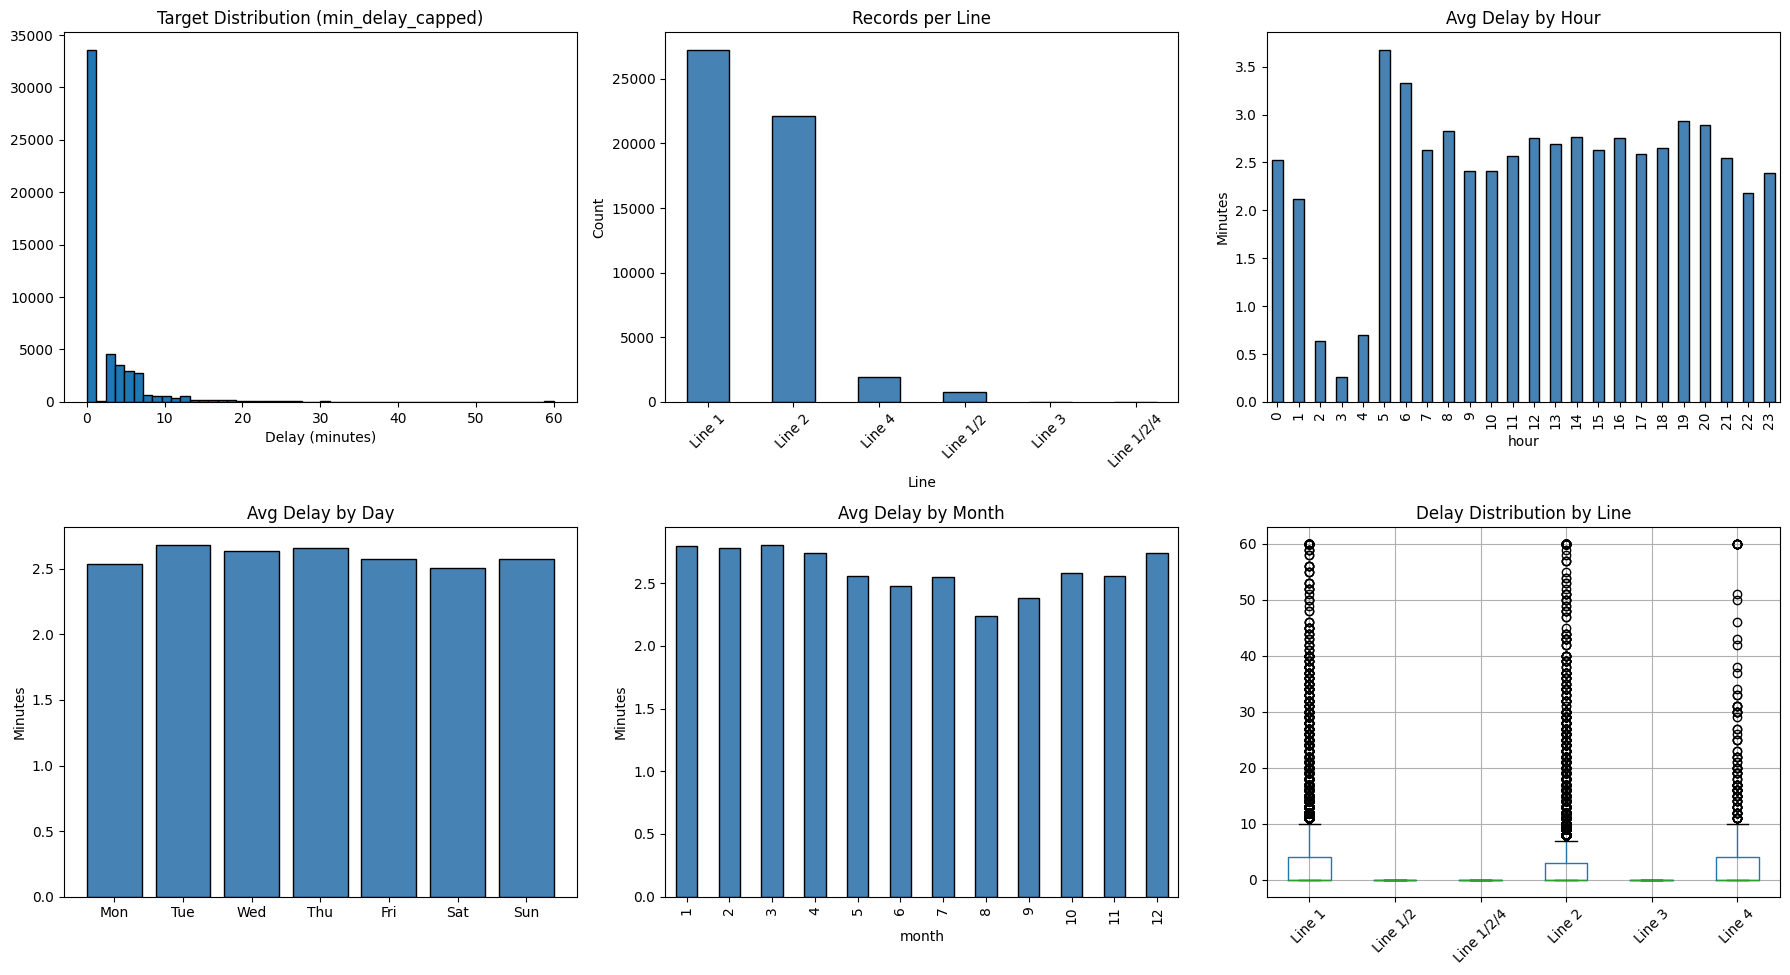

In [192]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Data Overview', fontsize=16)

# Use df instead of df_export
data = df_export if 'df_export' in dir() else df_check

# 1. Target distribution
axes[0, 0].hist(data['min_delay_capped'], bins=50, edgecolor='black')
axes[0, 0].set_title('Target Distribution (min_delay_capped)')
axes[0, 0].set_xlabel('Delay (minutes)')

# 2. Records per Line
data['Line'].value_counts().plot(kind='bar', ax=axes[0, 1], edgecolor='black', color='steelblue')
axes[0, 1].set_title('Records per Line')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Average delay by hour
data.groupby('hour')['min_delay_capped'].mean().plot(kind='bar', ax=axes[0, 2], edgecolor='black', color='steelblue')
axes[0, 2].set_title('Avg Delay by Hour')
axes[0, 2].set_ylabel('Minutes')

# 4. Average delay by day of week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_avg = data.groupby('day_of_week')['min_delay_capped'].mean()
axes[1, 0].bar(days, day_avg.values, edgecolor='black', color='steelblue')
axes[1, 0].set_title('Avg Delay by Day')
axes[1, 0].set_ylabel('Minutes')

# 5. Average delay by month
data.groupby('month')['min_delay_capped'].mean().plot(kind='bar', ax=axes[1, 1], edgecolor='black', color='steelblue')
axes[1, 1].set_title('Avg Delay by Month')
axes[1, 1].set_ylabel('Minutes')

# 6. Delay by Line (box plot)
data.boxplot(column='min_delay_capped', by='Line', ax=axes[1, 2], vert=True)
axes[1, 2].set_title('Delay Distribution by Line')
axes[1, 2].set_xlabel('')
axes[1, 2].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()


### Data Overview — Key Observations

**1. Target Distribution (min_delay_capped)**
- Heavily zero-inflated: ~34,000 records (64.5%) have 0 delay
- Right-skewed: most non-zero delays are under 10 minutes
- A standard regression model will tend to predict 0 for everything — consider a two-stage approach (classify delay vs no-delay, then predict minutes)

**2. Records per Line**
- Line 1 (~27,200) and Line 2 (~22,100) dominate the dataset — 95% of all records
- Line 4 (~1,955) has limited data, Line 1/2, Line 3, and Line 1/2/4 have very few records (<750 combined)
- Model predictions for minority lines (Line 3, Line 1/2/4) will be unreliable due to insufficient data

**3. Avg Delay by Hour**
- Peak delays at hours 5-7 (early morning, ~3.0-3.5 min) — likely start-of-service issues
- Late night (hours 0-2) shows moderate delays (~2.1-2.6 min)
- Midday hours (8-15) are relatively stable (~2.3-2.7 min)
- Hour 3 has the lowest average delay (~0.3 min) — very few trains running

**4. Avg Delay by Day**
- Very consistent across days (~2.5-2.7 min) — day of week has minimal impact
- Tue/Wed/Thu slightly higher than Mon/Sat
- This aligns with the near-zero correlation we saw in the correlation matrix

**5. Avg Delay by Month**
- Winter months (Jan-Mar) show slightly higher delays (~2.7-2.8 min) — possible weather effect
- Summer months (Jun-Aug) show lower delays (~2.2-2.5 min)
- Pattern is subtle — month alone is a weak predictor

**6. Delay Distribution by Line (Box Plot)**
- All lines have median delay at 0 (the line inside the box)
- Line 1 and Line 4 have the widest spread of outliers (delays up to 60 min)
- Line 1/2 and Line 3 show almost no variation — too few records with delays


In [193]:
# We will drop only Line 3 and Line 1/2/4 (closed/insufficient data)
# Keep Line 1/2 (~730 records) — enough to learn from
data = data[~data['Line'].isin(['Line 3', 'Line 1/2/4'])]
print(data['Line'].value_counts())


Line
Line 1      27233
Line 2      22134
Line 4       1956
Line 1/2      736
Name: count, dtype: int64


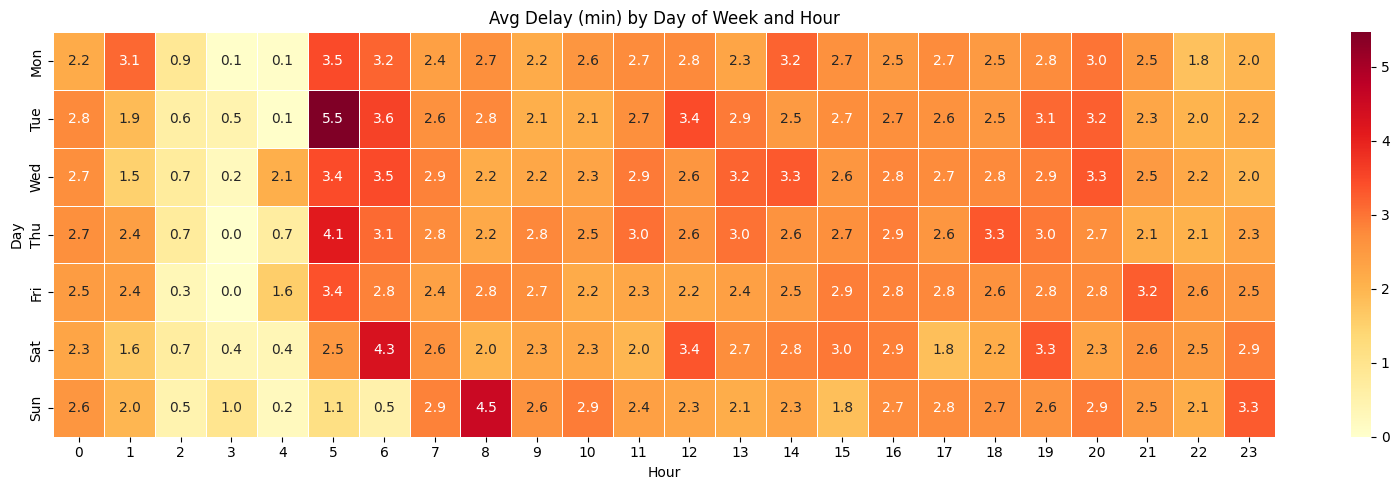

In [194]:
# Heatmap: average delay by hour and day of week
pivot = data.pivot_table(values='min_delay_capped', index='day_of_week', columns='hour', aggfunc='mean')
pivot.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(16, 5))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Avg Delay (min) by Day of Week and Hour')
plt.xlabel('Hour')
plt.ylabel('Day')
plt.tight_layout()
plt.show()


### Heatmap: Avg Delay by Day of Week and Hour

**Peak delay hotspots:**
- **Tuesday 5am (5.5 min)** — highest average delay in the entire dataset
- **Sunday 8am (4.5 min)** — likely reduced weekend service causing longer delays
- **Saturday 6am (4.3 min)** — same weekend early-morning pattern
- **Thursday 5am (4.1 min)** — early morning consistently problematic

**Low delay periods:**
- **Hours 2-4 across all days (0.0-1.0 min)** — minimal service, minimal delays
- **Friday 3am (0.0 min)** — effectively no delays

**Patterns:**
- **Early morning (5-6am) is the worst time across all days** — start-of-service issues, likely train positioning and crew changeovers
- **Midday (9am-4pm) is stable** at ~2.2-2.8 min across all days
- **Weekdays vs weekends show different peak times** — weekday peaks at 5-6am (rush hour startup), weekend peaks shift later to 6-8am
- **Evening hours (19-22) show a slight bump** (~2.5-3.3 min) — possible end-of-rush-hour congestion

**Modeling insight:** The combination of hour + day_of_week captures meaningful variation (0.0 to 5.5 min range). This supports keeping both features despite their low individual correlations — they interact with each other.


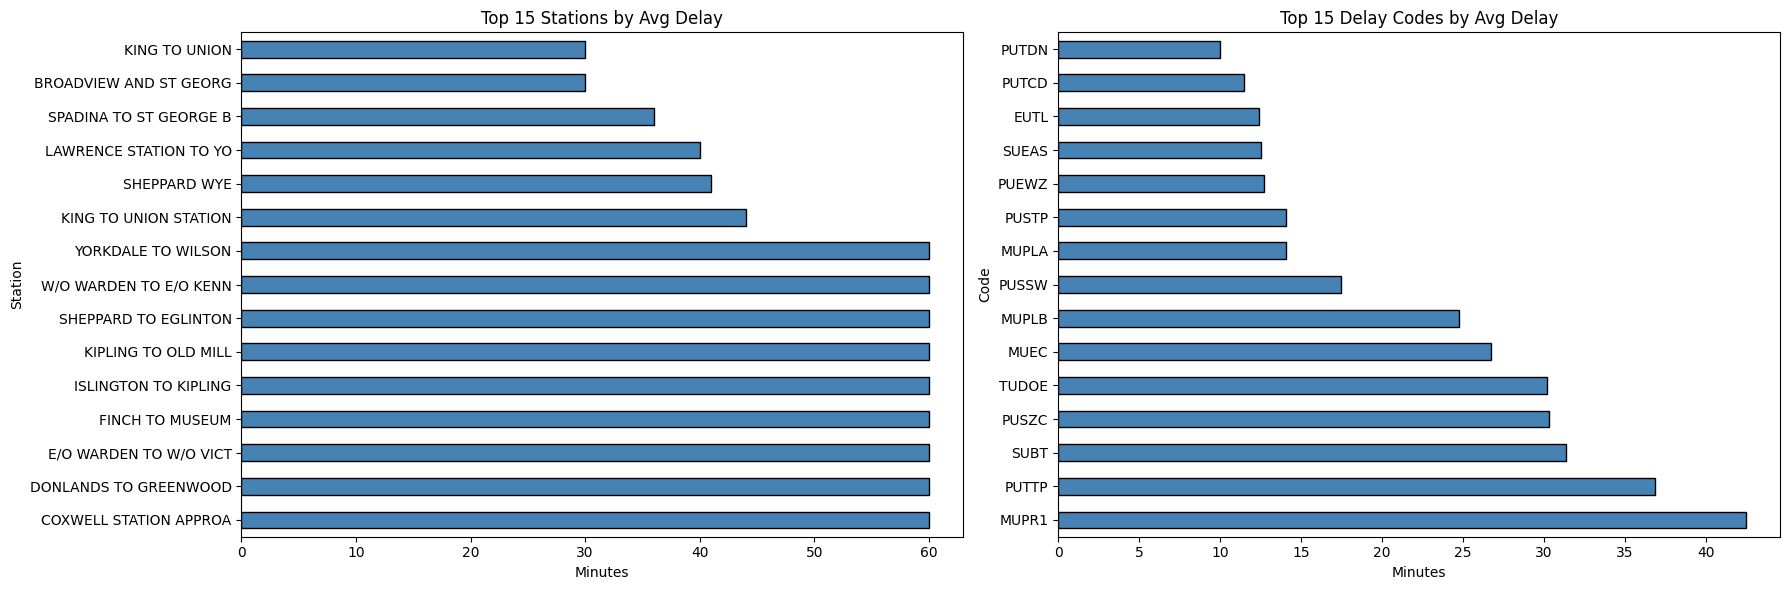

In [195]:
# Top 15 stations and delay codes with highest average delay
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data.groupby('Station')['min_delay_capped'].mean().nlargest(15).plot(
    kind='barh', ax=axes[0], edgecolor='black', color='steelblue')
axes[0].set_title('Top 15 Stations by Avg Delay')
axes[0].set_xlabel('Minutes')

data.groupby('Code')['min_delay_capped'].mean().nlargest(15).plot(
    kind='barh', ax=axes[1], edgecolor='black', color='steelblue')
axes[1].set_title('Top 15 Delay Codes by Avg Delay')
axes[1].set_xlabel('Minutes')

plt.tight_layout()
plt.show()


### Top 15 Stations and Delay Codes by Average Delay

**Top Stations:**
- The highest-delay stations are **between-station segments** (e.g., "COXWELL STATION APPROA", "DONLANDS TO GREENWOOD", "FINCH TO MUSEUM") — these represent delays that occur while trains are in transit, not at platforms
- Top stations average **50-60 min delays** — these are rare, severe incidents (likely single events that hit the 60 min cap)
- Named stations like "KING TO UNION" and "BROADVIEW AND ST GEORG" appear at the lower end (~30 min) — still severe but less extreme
- **Caution:** These high averages are likely driven by 1-2 extreme incidents, not consistent patterns. Check record counts before drawing conclusions.

**Top Delay Codes:**
- **MUPR1 (~43 min)** and **PUTTP (~38 min)** are the worst codes — these likely represent major infrastructure or power failures
- Codes starting with **PU** (e.g., PUTTP, PUSZC, PUSSW, PUSTP, PUEWZ) suggest power/utility-related issues
- Codes starting with **MU** (e.g., MUPR1, MUEC, MUPLB, MUPLA) suggest mechanical/unit issues
- **SUBT (~35 min)** and **TUDOE (~30 min)** — possibly subway-related and track-related delays
- The spread is wide (10-43 min) — `Code` carries strong predictive signal for delay severity

**Modeling insight:** `Code` is a strong feature — the top codes average 3-4x higher delays than the dataset mean (2.8 min). Worth encoding during model training despite having 131 unique values.


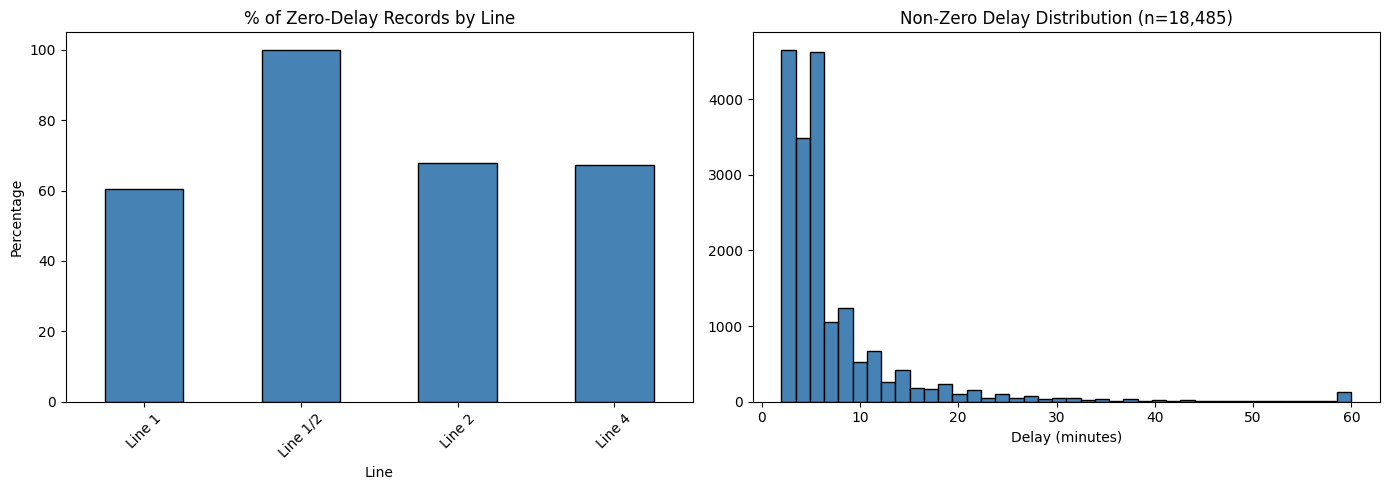

In [196]:
# Zero vs non-zero delay breakdown by line
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Percentage of zero-delay records per line
zero_pct = data.groupby('Line')['min_delay_capped'].apply(lambda x: (x == 0).mean() * 100)
zero_pct.plot(kind='bar', ax=axes[0], edgecolor='black', color='steelblue')
axes[0].set_title('% of Zero-Delay Records by Line')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=45)

# Distribution of non-zero delays only
non_zero = data[data['min_delay_capped'] > 0]['min_delay_capped']
axes[1].hist(non_zero, bins=40, edgecolor='black', color='steelblue')
axes[1].set_title(f'Non-Zero Delay Distribution (n={len(non_zero):,})')
axes[1].set_xlabel('Delay (minutes)')

plt.tight_layout()
plt.show()


### Zero-Delay Analysis

**% of Zero-Delay Records by Line:**
- **Line 1/2: 100% zero-delay** — combined-line incidents are logged but never result in actual measured delay. This line adds no predictive value for regression.
- **Line 1: ~61% zero-delay** — best ratio of actual delays, most useful for training
- **Line 2: ~68% zero-delay** — similar to Line 4
- **Line 4: ~67% zero-delay** — comparable to Line 2

**Non-Zero Delay Distribution (n=18,485):**
- When delays DO happen, most are **2-5 minutes** (peak around 3-5 min, ~4,500-4,700 records each)
- Sharp drop-off after 10 minutes — delays over 10 min are increasingly rare
- Small spike at **60 min** (~200 records) — these are the capped outliers (originally > 60 min)
- The distribution is much more usable than the full dataset — a two-stage model trained only on non-zero delays would have a reasonable distribution to learn from

**Modeling insight:** Line 1/2 has zero actual delays — consider dropping it for regression training. For the two-stage approach, Stage 2 (predicting minutes) would train on these 18,485 non-zero records, which have a much healthier distribution than the full 52K dataset.


In [197]:
data.to_csv('../data/processing/cleaned_ttc_delay_data.csv', index=False, encoding='utf-8')
print("Exported successfully")

Exported successfully
